In [246]:
import pandas as pd
import re

hits_excel_path = 'Supplementary_Table_11_CRISPR_DepMap_analysis.xlsx'
prediction_data = pd.read_excel(hits_excel_path, sheet_name=None)

In [26]:
# We can see the structure of hits_data : it's a dictionary with sheet names as keys, containing the dataframes as values

prediction_data['SMARCA4'].head()

,mutant,gene,num_lines_high,num_lines_low,estimate,p_adj
0,SMARCA4,CDAN1,97,98,-0.485750,4.039878e-09
1,SMARCA4,CDIN1,97,98,-0.224043,1.315044e-08
2,SMARCA4,MICOS10,97,98,-0.255113,1.518594e-06
3,SMARCA4,CBFB,97,98,-0.196786,1.982028e-06
4,SMARCA4,SDHD,97,98,-0.254965,3.671643e-06


In [27]:
# We can see the shape of the dataframe : it contains thousants of tested pairs. We want to extract those with a sufficiently high p_adj value

prediction_data['SMARCA4'].shape

(10052, 6)

In [28]:
# We first get the full list of genes that were tested for synthetic lethality in our study 

tested_genes = prediction_data.keys()
tested_genes_list = list(tested_genes)

print(tested_genes_list)

['ARID1A', 'ARID1B', 'ARID2', 'PBRM1', 'SMARCA2', 'SMARCA4', 'SMARCB1', 'BAP1', 'CREBBP', 'EED', 'KMT2C', 'KMT2D', 'SETD2']


In [29]:
# now, we can make sure to drop all gene pairs that don't have high enough p_adj values, for all tested genes
hits_data = {}

for gene in tested_genes_list:
    hits_data[gene] = prediction_data[gene][prediction_data[gene]['p_adj'] < 0.001]

# We get a much smaller proportion of the initial data (only 105 lines), which is expected. 

hits_data['SMARCA4'].shape

(105, 6)

In [245]:
# Then, we get all gene pairs that are included in the SynLethDB dataset : this is what we will compare our predictions to

def load_bm_data(filename):
  gene_sl_gene_df = pd.read_csv(filename, sep='\t')

  gene_sl_gene_df2 = gene_sl_gene_df[['x_name', 'y_name', 'rel_source']]

  positive_bm_df = gene_sl_gene_df2[gene_sl_gene_df['x_name'].isin(tested_genes_list) | gene_sl_gene_df['y_name'].isin(tested_genes_list)]

  return positive_bm_df


positive_bm_df = load_bm_data(filename='gene_sl_gene.tsv')

positive_bm_df.head()

,x_name,y_name,rel_source
173,PTTG1,CREBBP,Text Mining
346,ARID1A,MMP19,Computational Prediction
422,CDH1,SMARCA4,High Throughput
536,ARID2,CDK9,High Throughput
759,KMT2D,MYH4,Computational Prediction


In [33]:
print(gene_sl_gene_df2.shape)
print(positive_bm_df.shape)

(37943, 3)
(261, 3)


In [312]:
# Now, we demonstrate our pipeline with SMARCA4 as the gene of interest

tested_gene = 'ARID1B'

# We will store all SLI pairs as pandas dataframes withing dictionaries, similar to how our hits_data is structured

studied_sli_list = known_sli = identified_sli = {}

# First, we get the subset of known SLIs from SynLethDB where either 'x_name' or 'y_name' is the tested_gene
known_sli[tested_gene] = positive_bm_df[
    (positive_bm_df['x_name'] == tested_gene) | (positive_bm_df['y_name'] == tested_gene)
].copy()  # Make a copy to avoid setting on a slice

known_sli[tested_gene]

,x_name,y_name,rel_source
3658,ARID1B,NRAS,GenomeRNAi
4839,ARID1B,THBS3,Computational Prediction
5196,KRAS,ARID1B,RNAi Screen;High Throughput
5914,ARID1A,ARID1B,Text Mining;High Throughput
13634,ARID1B,NINJ2,Computational Prediction
14388,ARID1B,BCLAF1,Computational Prediction
16569,ARID1B,SHARPIN,Computational Prediction
20539,ARID1B,HRAS,GenomeRNAi
26278,ARID1B,TBP,Computational Prediction
26909,ARID1B,BPTF,Computational Prediction


In [313]:
# Then, we make sure the database is properly structured for our analysis, distinguishing between the "mutant" gene of interest and the other gene in the pair

# Create a copy to avoid modifying the original DataFrame

known_sli_tidy = {}

known_sli_tidy[tested_gene] = known_sli[tested_gene].copy()

# Check if tested_gene is in y_name column
mask = known_sli_tidy[tested_gene]['y_name'] == tested_gene  # Fix: Compare only y_name column

if mask.any():
    # Swap x_name and y_name where tested_gene is in y_name
    known_sli_tidy[tested_gene].loc[mask, ['x_name', 'y_name']] = known_sli_tidy[tested_gene].loc[mask, ['y_name', 'x_name']].values

# Rename the columns
known_sli_tidy[tested_gene].columns = ['mutant', 'gene', 'source']

known_sli_tidy[tested_gene]

,mutant,gene,source
3658,ARID1B,NRAS,GenomeRNAi
4839,ARID1B,THBS3,Computational Prediction
5196,ARID1B,KRAS,RNAi Screen;High Throughput
5914,ARID1B,ARID1A,Text Mining;High Throughput
13634,ARID1B,NINJ2,Computational Prediction
14388,ARID1B,BCLAF1,Computational Prediction
16569,ARID1B,SHARPIN,Computational Prediction
20539,ARID1B,HRAS,GenomeRNAi
26278,ARID1B,TBP,Computational Prediction
26909,ARID1B,BPTF,Computational Prediction


In [314]:
known_sli_filtered = {}

known_sli_filtered[tested_gene] = pd.merge(left=known_sli_tidy[tested_gene], right=prediction_data[tested_gene], on="gene", how="left")

known_sli_filtered[tested_gene] = known_sli_filtered[tested_gene].drop(columns=["mutant_y", "num_lines_high", "num_lines_low"])

known_sli_filtered[tested_gene]= known_sli_filtered[tested_gene].rename(columns={"mutant_x":"mutant"})

known_sli_filtered[tested_gene] = known_sli_filtered[tested_gene].dropna()

sources_to_exclude = "Text Mining|Computational Prediction|Drug Inhibition"

known_sli_filtered[tested_gene] = known_sli_filtered[tested_gene][~known_sli_filtered[tested_gene]["source"].str.contains(sources_to_exclude)]

known_sli_filtered[tested_gene] 

,mutant,gene,source,estimate,p_adj
0,ARID1B,NRAS,GenomeRNAi,-0.005371,0.827373
2,ARID1B,KRAS,RNAi Screen;High Throughput,0.022872,1.000000
7,ARID1B,HRAS,GenomeRNAi,0.000596,1.000000


In [330]:
# Let's merge our benchmark data with our model's outputs so that we can compare the two
# Here, we also filter our data to only include relevant benchmark sources, and gene pairs that were studied by our model
def filter_benchmark_data(bm_data, prediction_data, printratio = "True"):
    known_sli_filtered = {}
    pattern = "Text Mining|Computational Prediction|Drug Inhibition"
    for tested_gene in tested_genes_list:
        # Get the subset of the DataFrame where either 'x_name' or 'y_name' is the tested_gene
        known_sli[tested_gene] = bm_data[
            (bm_data['x_name'] == tested_gene) | (bm_data['y_name'] == tested_gene)
        ].copy()  # Make a copy to avoid setting on a slice

        # Create a copy to avoid modifying the original DataFrame
        known_sli_tidy[tested_gene] = known_sli[tested_gene].copy()

        # Check if tested_gene is in y_name column
        mask = known_sli_tidy[tested_gene]['y_name'] == tested_gene  # Fix: Compare only y_name column

        if mask.any():
            # Swap x_name and y_name where tested_gene is in y_name
            known_sli_tidy[tested_gene].loc[mask, ['x_name', 'y_name']] = known_sli_tidy[tested_gene].loc[mask, ['y_name', 'x_name']].values

        # Rename the columns
        known_sli_tidy[tested_gene].columns = ['mutant', 'gene', 'source']

        known_sli_filtered[tested_gene] = pd.merge(left=known_sli_tidy[tested_gene], right=prediction_data[tested_gene], on="gene", how="left")

        known_sli_filtered[tested_gene] = known_sli_filtered[tested_gene].drop(columns=["mutant_y", "num_lines_high", "num_lines_low"])

        known_sli_filtered[tested_gene]= known_sli_filtered[tested_gene].rename(columns={"mutant_x":"mutant"})

        known_sli_filtered[tested_gene] = known_sli_filtered[tested_gene].dropna()

        pattern = "Text Mining|Computational Prediction|Drug Inhibition"

        known_sli_filtered[tested_gene] = known_sli_filtered[tested_gene][~known_sli_filtered[tested_gene]["source"].str.contains(pattern)]

        if printratio == "True":
            included_genes_n = known_sli_filtered[tested_gene].shape[0]
            synlethdb_genes_n = known_sli_tidy[tested_gene].shape[0]
            if synlethdb_genes_n != 0:
                included_genes_ratio= included_genes_n / synlethdb_genes_n
                print(f"{tested_gene} included genes ratio:    {included_genes_ratio:.3f}     sample size : {included_genes_n}/{synlethdb_genes_n}")
            else:
                included_genes_ratio[tested_gene] = 'N/A'
                print(f"{tested_gene} included genes ratio:    {included_genes_ratio:.3f}     sample size : {included_genes_n}/{synlethdb_genes_n}")

    return known_sli_filtered


known_sli_filtered = filter_benchmark_data(positive_bm_df, prediction_data, printratio="True")

known_sli_filtered['ARID1B']

ARID1A included genes ratio:    0.400     sample size : 10/25
ARID1B included genes ratio:    0.250     sample size : 3/12
ARID2 included genes ratio:    0.941     sample size : 32/34
PBRM1 included genes ratio:    0.875     sample size : 21/24
SMARCA2 included genes ratio:    0.125     sample size : 1/8
SMARCA4 included genes ratio:    0.576     sample size : 19/33
SMARCB1 included genes ratio:    0.692     sample size : 18/26
BAP1 included genes ratio:    0.250     sample size : 1/4
CREBBP included genes ratio:    0.038     sample size : 2/52
EED included genes ratio:    0.000     sample size : 0/2
KMT2C included genes ratio:    0.000     sample size : 0/20
KMT2D included genes ratio:    0.467     sample size : 7/15
SETD2 included genes ratio:    0.933     sample size : 14/15


,mutant,gene,source,estimate,p_adj
0,ARID1B,NRAS,GenomeRNAi,-0.005371,0.827373
2,ARID1B,KRAS,RNAi Screen;High Throughput,0.022872,1.000000
7,ARID1B,HRAS,GenomeRNAi,0.000596,1.000000


In [194]:
# We can now export our filtered data to excel
def save_data_to_excel(bm_data, filename):
    with pd.ExcelWriter(filename, engine="openpyxl") as writer:
        for sheet_name, df in bm_data.items():
            df.to_excel(writer, sheet_name=sheet_name, index=False)

save_data_to_excel(bm_data=known_sli_filtered, filename="synlethdb_known_slis.xlsx")

In [316]:
# Using the exact same logic as before, we create and filter our negative benchmark data

gene_nonsl_gene_df = pd.read_csv('gene_nonsl_gene.tsv', sep='\t')

gene_nonsl_gene_df2 = gene_nonsl_gene_df[['x_name', 'y_name', 'rel_source']]

negative_bm_df = gene_nonsl_gene_df2[gene_nonsl_gene_df2['x_name'].isin(tested_genes_list) | gene_nonsl_gene_df2['y_name'].isin(tested_genes_list)]

negative_bm_df.head()

,x_name,y_name,rel_source
9,CREBBP,KDM6B,High Throughput
125,ABL1,SETD2,High Throughput
152,ARID1A,ARID2,High Throughput
353,CREBBP,SIRT1,High Throughput
526,PIK3R1,SETD2,High Throughput


In [317]:
known_nonsli_filtered = filter_benchmark_data(negative_bm_df, prediction_data)

known_nonsli_filtered['ARID1B']

,mutant,gene,source,estimate,p_adj
0,ARID1B,ARID1A,High Throughput,0.028004,1.0


In [ ]:
save_data_to_excel(bm_data=known_nonsli_filtered, filename="synlethdb_known_nonslis.xlsx")

In [213]:
# Now, let's aggregate all of our data in a single table so that we can evaluate the model's performance on different metrics.

def dictionary_to_df(data_dict):
    result = pd.DataFrame()  
    for key in data_dict.keys():  
        result = pd.concat([result, data_dict[key]], ignore_index=True)  

    return result  

known_sli_table = dictionary_to_df(known_sli_filtered) 

known_nonsli_table = dictionary_to_df(known_nonsli_filtered)

In [321]:
included_genes_ratio = {}
for tested_gene in tested_genes_list:
    included_genes_n = known_sli_filtered[tested_gene].shape[0]
    synlethdb_genes_n = known_sli[tested_gene].shape[0]
    if synlethdb_genes_n != 0:
        included_genes_ratio[tested_gene] = included_genes_n / synlethdb_genes_n
        print(f"{tested_gene} included genes ratio:    {included_genes_ratio[tested_gene]}     sample size : {included_genes_n}/{synlethdb_genes_n}")
    else:
        included_genes_ratio[tested_gene] = 'N/A'
        print(f"{tested_gene} included genes ratio:    {included_genes_ratio[tested_gene]}     sample size : {included_genes_n}/{synlethdb_genes_n}")

ARID1A included genes ratio:    0.136986301369863     sample size : 10/73
ARID1B included genes ratio:    3.0     sample size : 3/1
ARID2 included genes ratio:    0.4444444444444444     sample size : 32/72
PBRM1 included genes ratio:    0.2916666666666667     sample size : 21/72
SMARCA2 included genes ratio:    1.0     sample size : 1/1
SMARCA4 included genes ratio:    0.25333333333333335     sample size : 19/75
SMARCB1 included genes ratio:    0.25     sample size : 18/72
BAP1 included genes ratio:    1.0     sample size : 1/1
CREBBP included genes ratio:    0.044444444444444446     sample size : 2/45
EED included genes ratio:    N/A     sample size : 0/0
KMT2C included genes ratio:    0.0     sample size : 0/1
KMT2D included genes ratio:    0.0958904109589041     sample size : 7/73
SETD2 included genes ratio:    0.12389380530973451     sample size : 14/113


In [220]:
known_sli_table

,mutant,gene,source,estimate,p_adj
0,ARID1A,RRM2,High Throughput,-0.028957,0.400100
1,ARID1A,CHEK1,High Throughput;CRISPR/CRISPRi,0.064255,1.000000
2,ARID1A,MAP3K1,High Throughput,0.014071,1.000000
3,ARID1A,APC,High Throughput,0.012093,1.000000
4,ARID1A,SMO,High Throughput,-0.006270,0.860552
...,...,...,...,...,...
123,SETD2,TSC1,High Throughput,0.044795,1.000000
124,SETD2,CDK9,CRISPR/CRISPRi,0.043171,1.000000
125,SETD2,HDAC2,High Throughput,0.003609,1.000000
126,SETD2,SMO,High Throughput,-0.023252,0.408815


In [223]:
known_nonsli_table

,mutant,gene,source,estimate,p_adj
0,ARID1A,ARID2,High Throughput,0.009233,1.000000
1,ARID1A,RRM2,High Throughput,-0.028957,0.400100
2,ARID1A,CASP8,High Throughput,-0.034419,0.174918
3,ARID1A,CHEK2,High Throughput,-0.065028,0.008915
4,ARID1A,KDM6A,High Throughput,0.020502,1.000000
...,...,...,...,...,...
562,SETD2,EZH2,High Throughput,-0.067811,0.126959
563,SETD2,FLT3,High Throughput,-0.019427,0.463636
564,SETD2,BRAF,High Throughput,-0.012194,0.770597
565,SETD2,CDKN1B,High Throughput,0.006144,1.000000


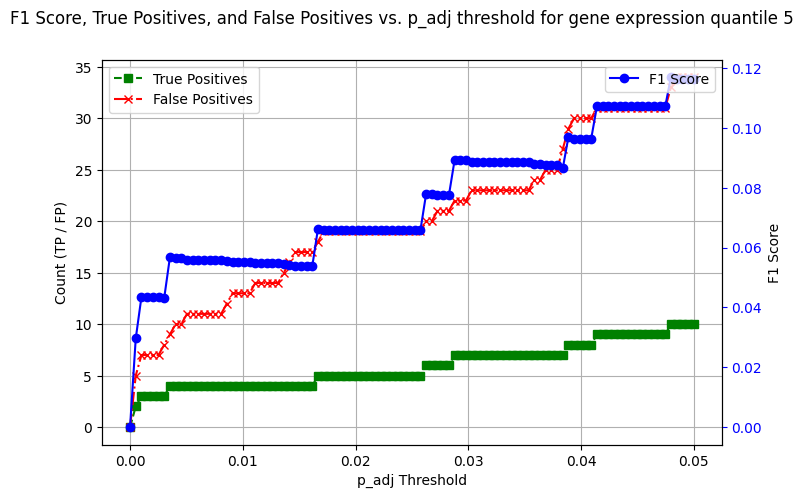

In [285]:
# Let's calculate true positives, false positives, etc :

import numpy as np
import matplotlib.pyplot as plt

def plot_F1_score(known_sli_table, known_nonsli_table, quantile):
    # Define a range of p_adj thresholds
    p_adj_values = np.linspace(0, 0.05, 100)  # Adjust range as needed
    f1_scores = []
    true_positives_list = []
    false_positives_list = []

    # Compute F1-score, TP, and FP for each threshold
    for p_adj_tresh in p_adj_values:
        true_positives = (known_sli_table["p_adj"] < p_adj_tresh).sum()
        false_positives = (known_nonsli_table["p_adj"] < p_adj_tresh).sum()
        false_negatives = (known_sli_table["p_adj"] > p_adj_tresh).sum()

        # Store TP and FP
        true_positives_list.append(true_positives)
        false_positives_list.append(false_positives)

        # Precision and Recall
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

        # Compute F1-score and scale by 100
        F1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(F1_score)

    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Primary Y-axis (TP and FP)
    ax1.plot(p_adj_values, true_positives_list, marker='s', linestyle='--', label="True Positives", color='green')
    ax1.plot(p_adj_values, false_positives_list, marker='x', linestyle='-.', label="False Positives", color='red')
    ax1.set_xlabel("p_adj Threshold")
    ax1.set_ylabel("Count (TP / FP)")
    ax1.tick_params(axis='y')

    # Secondary Y-axis for F1-score
    ax2 = ax1.twinx()
    ax2.plot(p_adj_values, f1_scores, marker='o', linestyle='-', label="F1 Score", color='blue')
    ax2.set_ylabel("F1 Score")
    ax2.tick_params(axis='y', colors='blue')

    # Title and legend
    fig.suptitle(f"F1 Score, True Positives, and False Positives vs. p_adj threshold for gene expression quantile {quantile}")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax1.grid(True)

    plt.show()

plot_F1_score(known_sli_table, known_nonsli_table, quantile=5)

# Now benchmarking the different quantile tresholds

In [288]:
# Loading all of the data

prediction_data_Q5 = pd.read_excel("CRISPR_DepMap_final_analysis_Q5.xlsx", sheet_name=None)

prediction_data_Q10 = pd.read_excel("CRISPR_DepMap_final_analysis_Q10.xlsx", sheet_name=None)

prediction_data_Q15 = pd.read_excel("CRISPR_DepMap_final_analysis_Q15.xlsx", sheet_name=None)

prediction_data_Q20 = pd.read_excel("CRISPR_DepMap_final_analysis_Q20.xlsx", sheet_name=None)

prediction_data_Q25 = pd.read_excel("CRISPR_DepMap_final_analysis_Q25.xlsx", sheet_name=None)

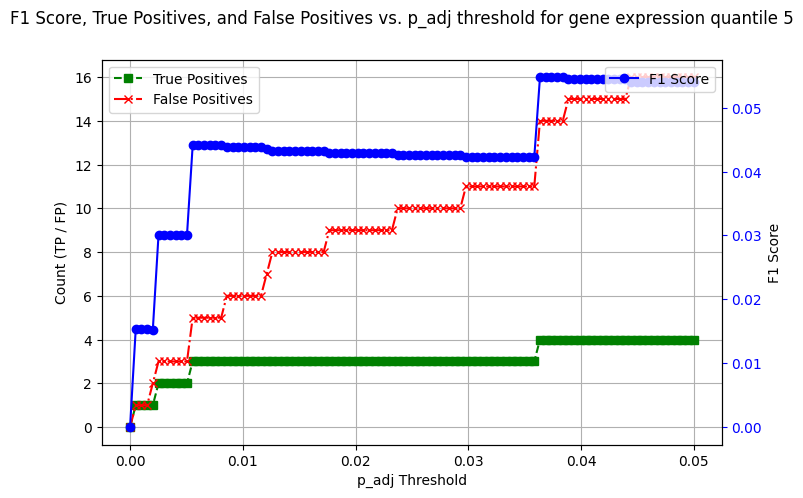

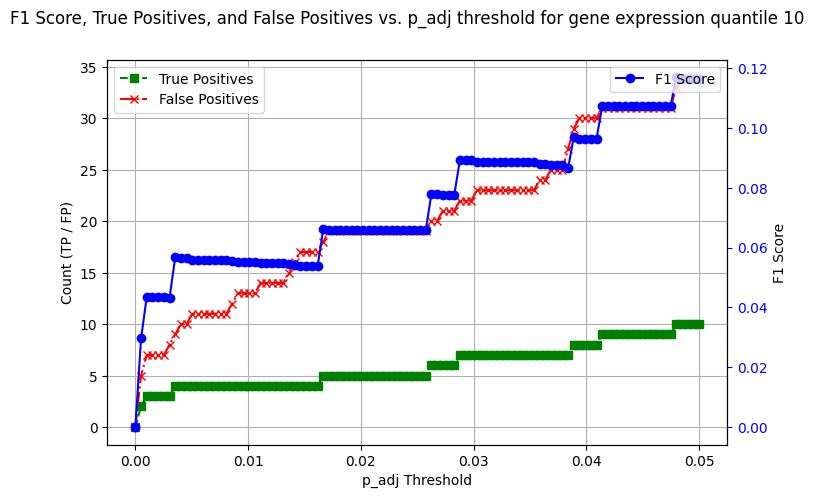

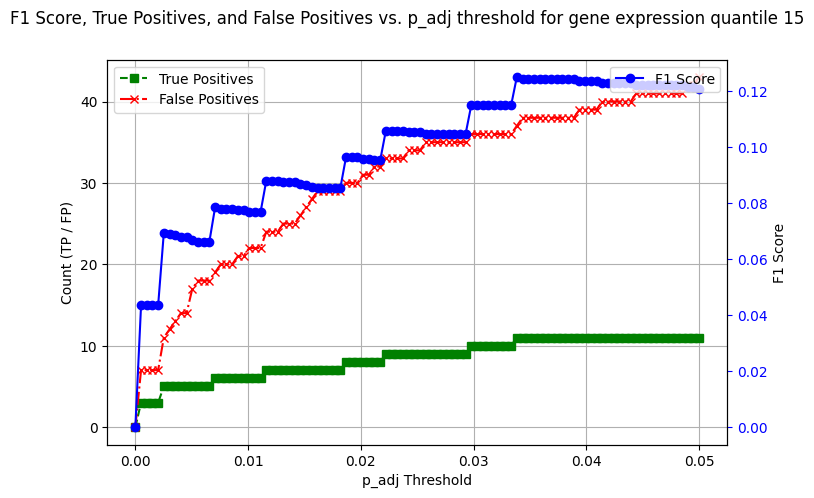

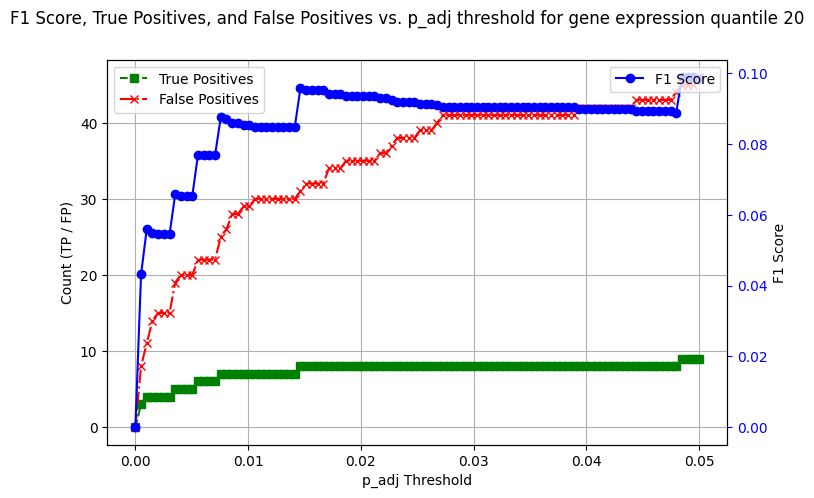

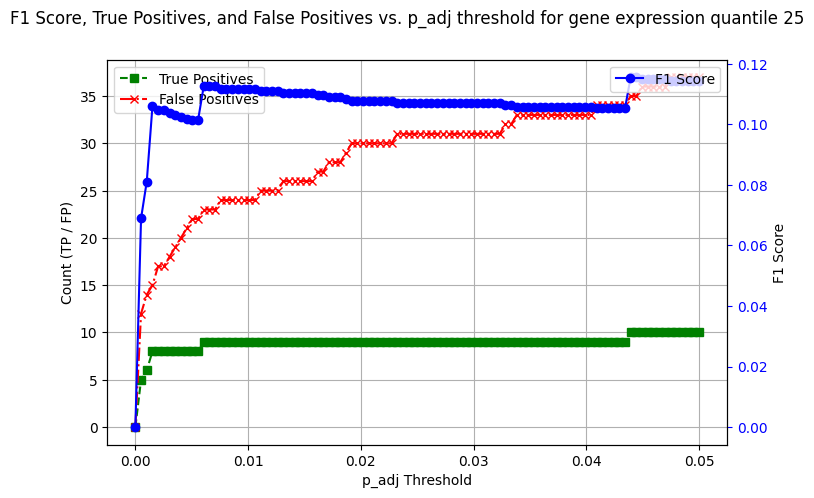

In [287]:
def process_prediction_data(prediction_data):
    known_sli_filtered = filter_benchmark_data(positive_bm_df, prediction_data)

    known_nonsli_filtered = filter_benchmark_data(negative_bm_df, prediction_data)

    known_sli_table = dictionary_to_df(known_sli_filtered)

    known_nonsli_table = dictionary_to_df(known_nonsli_filtered)

    return known_sli_table, known_nonsli_table

for quantile in range(5, 30, 5):
    prediction_data = globals().get(f"prediction_data_Q{quantile}")
    if prediction_data is not None:
        known_sli_table, known_nonsli_table = process_prediction_data(prediction_data)
        plot_F1_score(known_sli_table, known_nonsli_table, quantile=quantile)

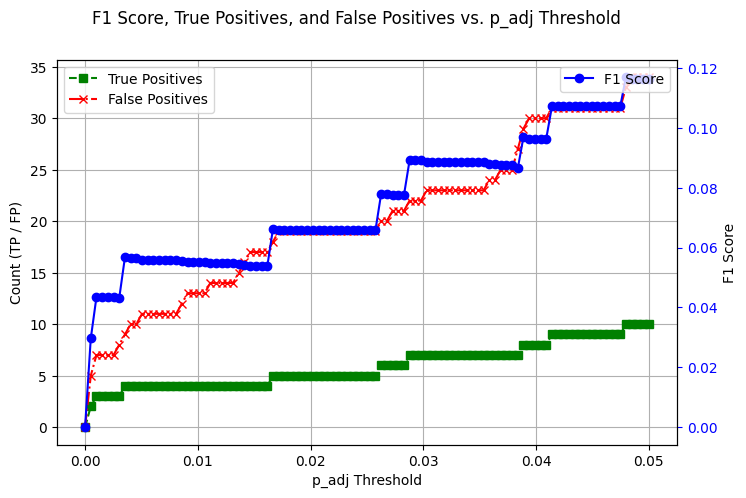

In [278]:
known_sli_table_Q10, known_nonsli_table_Q10 = process_prediction_data(prediction_data_Q10)

plot_F1_score(known_sli_table_Q10, known_nonsli_table_Q10)

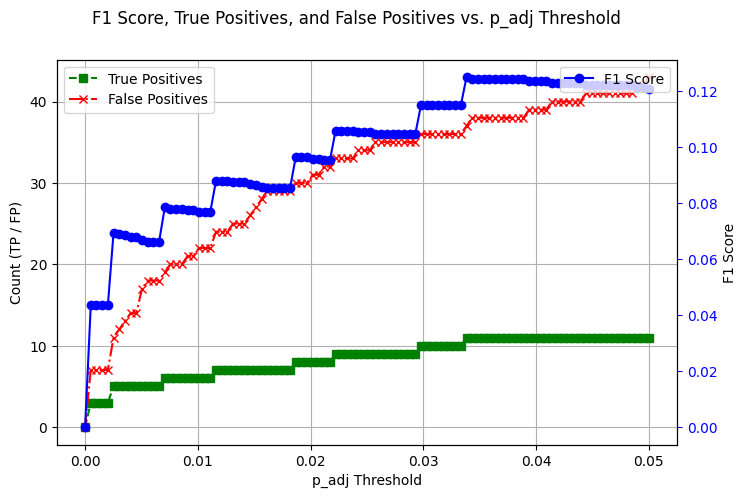

In [279]:
known_sli_table_Q15, known_nonsli_table_Q15 = process_prediction_data(prediction_data_Q15)

plot_F1_score(known_sli_table_Q15, known_nonsli_table_Q15)

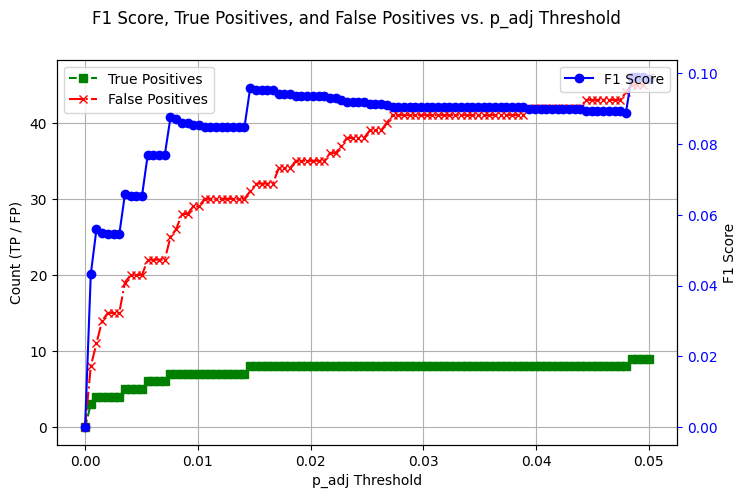

In [280]:
known_sli_table_Q20, known_nonsli_table_Q20 = process_prediction_data(prediction_data_Q20)

plot_F1_score(known_sli_table_Q20, known_nonsli_table_Q20)

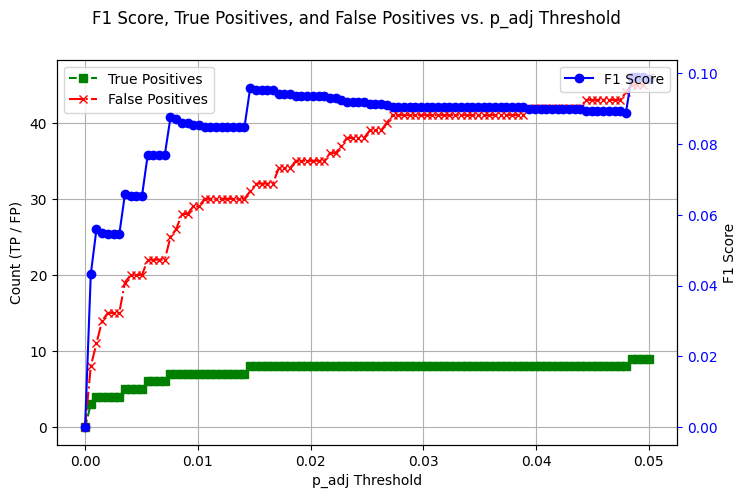

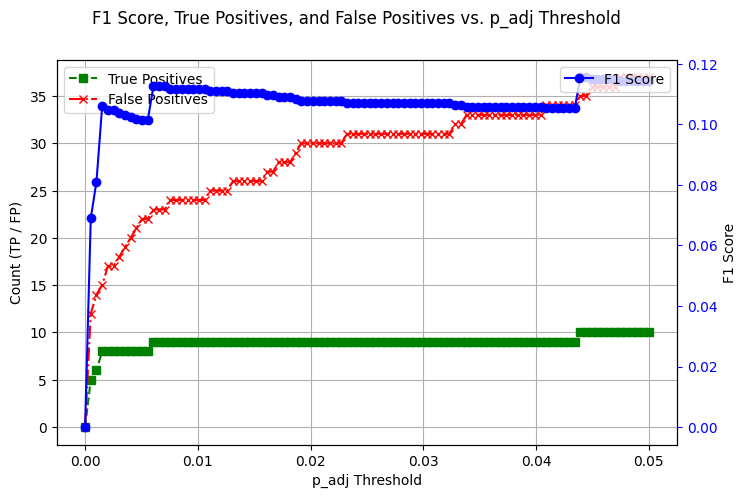

In [282]:
known_sli_table_Q25, known_nonsli_table_Q25 = process_prediction_data(prediction_data_Q25)


plot_F1_score(known_sli_table_Q25, known_nonsli_table_Q25)